# Image Noise Reduction

#### 1. Importing libraries

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

#### 2.  Data Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float')/255.
x_test  = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test  = np.reshape(x_test, (10000, 784))

11493376/11490434 [==============================] - 4s 0us/step


#### 3.  Adding Noise

In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784)*0.9
x_test_noisy  = x_test + np.random.rand(10000, 784)*0.9
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)

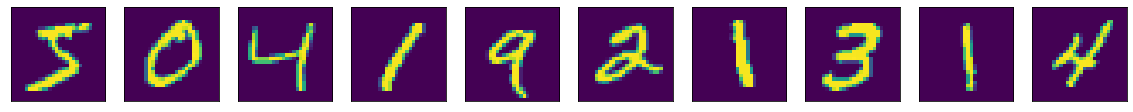

In [4]:
def Plot(x, p, labels = False):
    plt.figure(figsize = (20, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(x[i].reshape(28,28), cmap = 'viridis')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    
Plot(x_train, None)

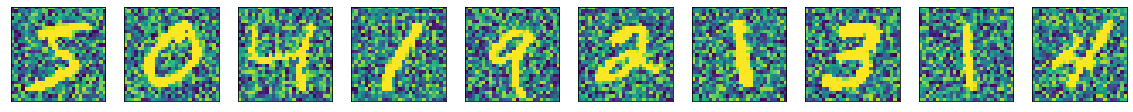

In [5]:
Plot(x_train_noisy, None)

#### 4. Building and Training a Classifier

In [6]:
classifier = Sequential([
    Dense(256, activation = 'relu', input_shape = (784,)),
    Dense(256, activation = 'relu'),
    Dense(256, activation = 'softmax')
])

classifier.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

classifier.fit(x_train, y_train, batch_size = 512, epochs = 3)

Epoch 1/3
118/118 [==============================] - 2s 14ms/step - loss: 0.7716 - accuracy: 0.8134
Epoch 2/3
118/118 [==============================] - 2s 13ms/step - loss: 0.2093 - accuracy: 0.9395
Epoch 3/3
118/118 [==============================] - 2s 13ms/step - loss: 0.1463 - accuracy: 0.9575


In [7]:
loss, acc = classifier.evaluate(x_test, y_test)

print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 0.9623
0.9623000025749207


In [8]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)

print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 12.9198 - accuracy: 0.1446
0.1446000039577484


#### 5.  Building the Autoencoder

In [9]:
input_image = Input(shape = (784,))
encoded = Dense(64, activation = 'relu')(input_image)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

#### 6.  Training the Autoencoder

In [10]:
autoencoder.fit(
    x_train_noisy, 
    x_train,
    epochs = 100,
    batch_size = 512,
    validation_split = 0.2,
    verbose = False,
    callbacks = [
        EarlyStopping(monitor = 'val_loss', patience = 5),
        LambdaCallback(on_epoch_end = lambda e,l: print('{:.3f}'.format(l['val_loss']), end = ' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.260 _ 0.229 _ 0.198 _ 0.180 _ 0.168 _ 0.159 _ 0.152 _ 0.146 _ 0.141 _ 0.137 _ 0.133 _ 0.130 _ 0.128 _ 0.125 _ 0.123 _ 0.122 _ 0.120 _ 0.118 _ 0.117 _ 0.116 _ 0.115 _ 0.115 _ 0.114 _ 0.113 _ 0.112 _ 0.112 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.109 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.107 _ 0.108 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _  _ 
Training is complete!


#### 7.  Denoised Images

In [11]:
preds = autoencoder.predict(x_test_noisy)

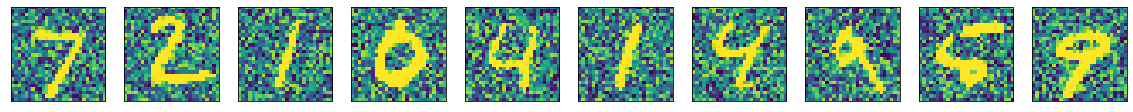

In [12]:
Plot(x_test_noisy, None)

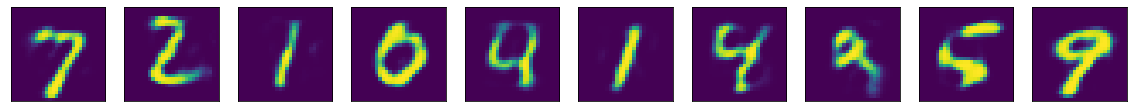

In [13]:
Plot(preds, None)

In [14]:
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2065 - accuracy: 0.9361
0.9361000061035156


#### 8.  Composite Model

In [15]:
input_image=Input(shape=(784,))
x=autoencoder(input_image)
y=classifier(x)

denoise_and_classfiy = Model(input_image, y)

In [16]:
predictions=denoise_and_classfiy.predict(x_test_noisy)

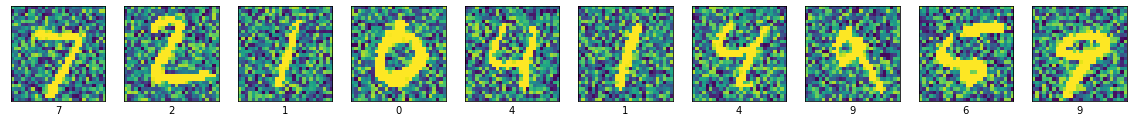

In [17]:
Plot(x_test_noisy, predictions, True)

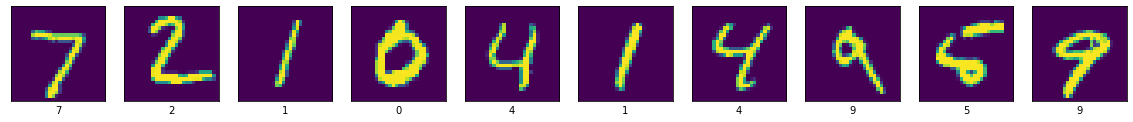

In [18]:
Plot(x_test, to_categorical(y_test), True)